In [8]:
!pip install opencv-python numpy matplotlib mediapipe deepface tqdm yt-dlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.0 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import os
from tqdm import tqdm
from deepface import DeepFace


25-03-09 05:17:24 - Directory /root/.deepface has been created
25-03-09 05:17:24 - Directory /root/.deepface/weights has been created


In [9]:
def download_video(url, output_path="input_video.mp4"):
    """
    Download a video from YouTube
    """
    # Using yt-dlp which is more reliable than pytube
    !yt-dlp -f "best[height<=720]" {url} -o {output_path}
    return output_path

# Test with a short video
video_path = download_video("https://www.youtube.com/watch?v=v_kTNIYsFnQ", "test_video.mp4")

[youtube] Extracting URL: https://www.youtube.com/watch?v=v_kTNIYsFnQ
[youtube] v_kTNIYsFnQ: Downloading webpage
[youtube] v_kTNIYsFnQ: Downloading tv client config
[youtube] v_kTNIYsFnQ: Downloading player f6e09c70
[youtube] v_kTNIYsFnQ: Downloading tv player API JSON
[youtube] v_kTNIYsFnQ: Downloading ios player API JSON
[youtube] v_kTNIYsFnQ: Downloading m3u8 information
[info] v_kTNIYsFnQ: Downloading 1 format(s): 18
[download] Destination: test_video.mp4
[download] 100% of   29.19MiB in 00:00:00 at 51.64MiB/s


In [10]:
def detect_faces_in_video(video_path, output_folder="detected_faces", sample_rate=5):
    """
    Extract faces from video frames at regular intervals
    """
    # Create output folder
    os.makedirs(output_folder, exist_ok=True)

    # Initialize MediaPipe face detector (simpler than OpenCV's DNN)
    mp_face_detection = mp.solutions.face_detection
    face_detector = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

    # Open video
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Prepare output list
    detected_faces = []

    # Process frames
    for frame_idx in tqdm(range(0, total_frames, sample_rate)):
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if not ret:
            break

        # Convert to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect faces
        results = face_detector.process(rgb_frame)

        # Process detections
        if results.detections:
            h, w = frame.shape[:2]

            for i, detection in enumerate(results.detections):
                # Get face bounding box
                bbox = detection.location_data.relative_bounding_box
                x = int(bbox.xmin * w)
                y = int(bbox.ymin * h)
                width = int(bbox.width * w)
                height = int(bbox.height * h)

                # Ensure coordinates are valid
                x = max(0, x)
                y = max(0, y)
                if x + width > w: width = w - x
                if y + height > h: height = h - y

                # Skip invalid faces
                if width <= 0 or height <= 0:
                    continue

                # Extract face image
                face_img = frame[y:y+height, x:x+width]

                # Save face image
                timestamp = frame_idx / fps
                face_filename = f"{output_folder}/frame_{frame_idx}_face_{i}.jpg"
                cv2.imwrite(face_filename, face_img)

                # Add to results
                detected_faces.append({
                    'frame': frame_idx,
                    'timestamp': timestamp,
                    'face_id': i,
                    'face_path': face_filename,
                    'bbox': (x, y, width, height)
                })

    # Close video
    cap.release()

    print(f"Detected {len(detected_faces)} faces in {len(range(0, total_frames, sample_rate))} frames")
    return detected_faces

# Extract faces
faces = detect_faces_in_video(video_path)

100%|██████████| 2310/2310 [03:13<00:00, 11.94it/s]

Detected 2586 faces in 2310 frames


In [11]:
def analyze_emotions(face_list):
    """
    Analyze emotions in detected faces
    """
    results = []

    print("Analyzing emotions...")
    for face in tqdm(face_list):
        try:
            # Analyze with DeepFace
            emotion_analysis = DeepFace.analyze(
                img_path=face['face_path'],
                actions=['emotion'],
                enforce_detection=False
            )

            # Get emotion data
            dominant_emotion = emotion_analysis[0]['dominant_emotion']
            emotion_scores = emotion_analysis[0]['emotion']

            # Store results
            results.append({
                'frame': face['frame'],
                'timestamp': face['timestamp'],
                'face_id': face['face_id'],
                'dominant_emotion': dominant_emotion,
                'emotion_scores': emotion_scores,
                'face_path': face['face_path']
            })
        except Exception as e:
            print(f"Error analyzing face {face['face_path']}: {e}")

    return results

# Analyze emotions
emotion_results = analyze_emotions(faces)

Analyzing emotions...


  0%|          | 0/2586 [00:00<?, ?it/s]

25-03-09 05:24:29 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5

100%|██████████| 5.98M/5.98M [00:00<00:00, 62.8MB/s]
100%|██████████| 2586/2586 [01:36<00:00, 26.83it/s]


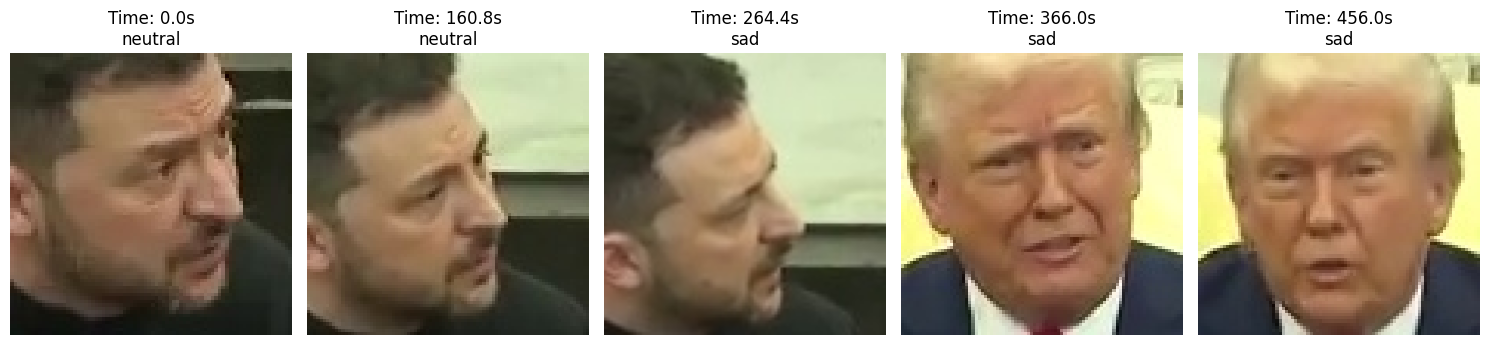

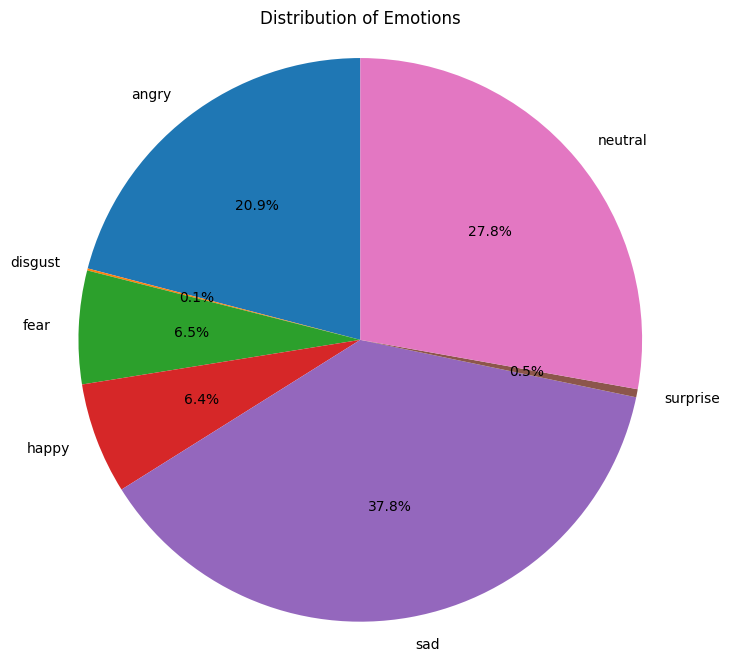

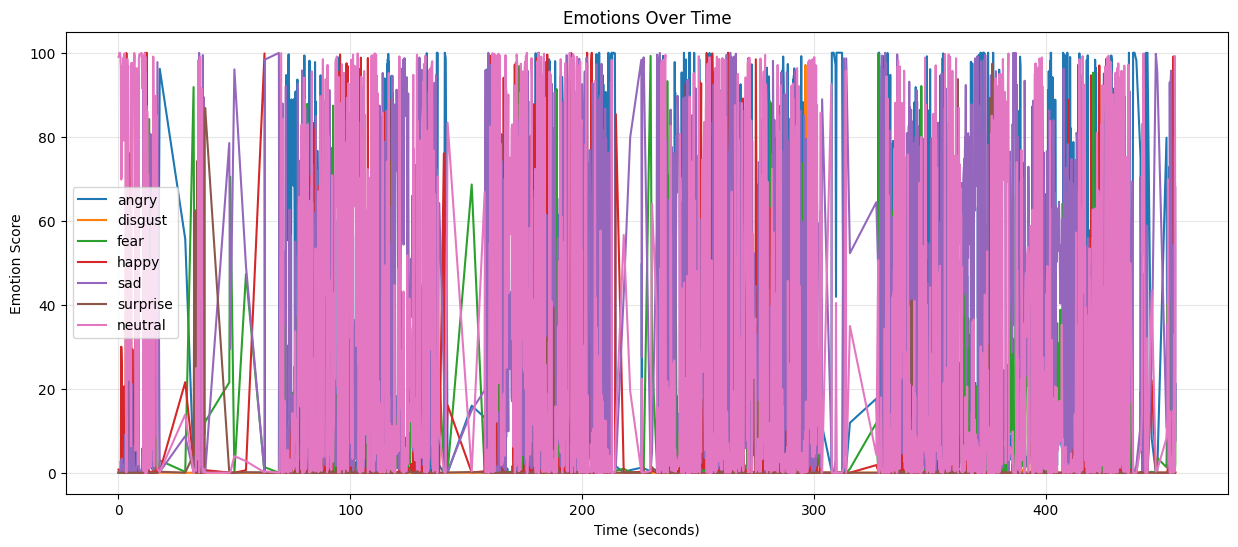

In [12]:
def visualize_results(emotion_results, num_samples=5):
    """
    Create visualizations of the emotion analysis results
    """
    # 1. Sample images with emotion labels
    if len(emotion_results) > 0:
        # Choose samples
        sample_indices = np.linspace(0, len(emotion_results)-1, num_samples, dtype=int)
        samples = [emotion_results[i] for i in sample_indices]

        # Create figure
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
        if num_samples == 1:
            axes = [axes]

        # Plot samples
        for i, sample in enumerate(samples):
            # Load image
            img = cv2.imread(sample['face_path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Plot
            axes[i].imshow(img)
            axes[i].set_title(f"Time: {sample['timestamp']:.1f}s\n{sample['dominant_emotion']}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    # 2. Emotion distribution pie chart
    emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    emotion_counts = {emotion: 0 for emotion in emotions}

    for result in emotion_results:
        emotion_counts[result['dominant_emotion']] += 1

    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(
        [emotion_counts[e] for e in emotions if emotion_counts[e] > 0],
        labels=[e for e in emotions if emotion_counts[e] > 0],
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title('Distribution of Emotions')
    plt.axis('equal')
    plt.show()

    # 3. Emotion over time
    timestamps = [r['timestamp'] for r in emotion_results]
    emotion_values = {emotion: [] for emotion in emotions}

    for result in emotion_results:
        for emotion in emotions:
            emotion_values[emotion].append(result['emotion_scores'].get(emotion, 0))

    # Create line chart
    plt.figure(figsize=(15, 6))
    for emotion in emotions:
        plt.plot(timestamps, emotion_values[emotion], label=emotion)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Emotion Score')
    plt.title('Emotions Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize the results
visualize_results(emotion_results)

In [14]:
def create_summary_video(video_path, emotion_results, faces_data, output_path="emotion_summary.mp4"):
    """
    Create a video with emotion labels overlaid
    Uses the original face detection data for bounding boxes
    """
    # Open input video
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Create lookup for face paths to bounding boxes
    face_path_to_bbox = {face['face_path']: face['bbox'] for face in faces_data}

    # Create frame -> emotion mapping
    frame_emotions = {}
    for result in emotion_results:
        frame = result['frame']
        if frame not in frame_emotions:
            frame_emotions[frame] = []

        # Add bbox from original detection data
        result['bbox'] = face_path_to_bbox.get(result['face_path'], (0, 0, 50, 50))  # Default if not found
        frame_emotions[frame].append(result)

    # Process video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_idx in tqdm(range(total_frames)):
        ret, frame = cap.read()
        if not ret:
            break

        # Add emotion labels if available
        if frame_idx in frame_emotions:
            for face_data in frame_emotions[frame_idx]:
                # Draw rectangle
                x, y, w, h = face_data['bbox']
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

                # Add emotion text
                emotion = face_data['dominant_emotion']
                cv2.putText(
                    frame, emotion, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2
                )

        # Add timestamp
        timestamp = frame_idx / fps
        cv2.putText(
            frame, f"Time: {timestamp:.1f}s", (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2
        )

        # Write frame to output
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

    print(f"Summary video saved to {output_path}")
    return output_path

# Create summary video with original face detection data
summary_video = create_summary_video(video_path, emotion_results, faces)

100%|██████████| 11547/11547 [00:37<00:00, 307.08it/s]

Summary video saved to emotion_summary.mp4


In [17]:
def add_voice_analysis_to_summary(video_path, emotion_results, original_summary_path=None, output_path="enhanced_summary.mp4"):
    """
    Add voice emotion analysis to an existing summary video or create a new one
    """
    import subprocess
    import librosa
    import numpy as np
    import tempfile

    # Step 1: Extract audio from the video
    audio_path = tempfile.gettempdir() + "/extracted_audio.wav"
    extract_cmd = [
        "ffmpeg", "-i", video_path,
        "-q:a", "0", "-map", "a", audio_path,
        "-y"  # Overwrite if exists
    ]
    subprocess.run(extract_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Step 2: Analyze audio (simple version)
    print("Analyzing audio emotions...")
    y, sr = librosa.load(audio_path)

    # Calculate audio features in segments
    segment_duration = 2  # seconds
    voice_emotions = []

    for i in range(0, len(y), int(sr * segment_duration)):
        segment = y[i:i + int(sr * segment_duration)]
        if len(segment) < sr:  # Skip too short segments
            continue

        # Extract basic features
        segment_energy = np.mean(librosa.feature.rms(y=segment)[0])
        segment_pitch = librosa.yin(segment, fmin=80, fmax=400, sr=sr)
        pitch_mean = np.mean(segment_pitch[~np.isnan(segment_pitch)])

        # Very simple rule-based classification
        if segment_energy > 0.05:
            if pitch_mean > 200:
                emotion = "excited"
            else:
                emotion = "assertive"
        else:
            if pitch_mean > 180:
                emotion = "neutral"
            else:
                emotion = "calm"

        voice_emotions.append({
            'timestamp': i / sr,
            'emotion': emotion,
            'energy': segment_energy,
            'pitch': pitch_mean
        })

    # Step 3: Modify the existing summary video (or create a new one)
    if original_summary_path is None:
        # If no summary exists, create one using your existing function
        # Assuming create_summary_video is your existing function
        original_summary_path = create_summary_video(video_path, emotion_results)

    # Step 4: Add voice information to the video
    cap = cv2.VideoCapture(original_summary_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create enhanced output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Process each frame and add voice emotion data
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_idx in tqdm(range(total_frames)):
        ret, frame = cap.read()
        if not ret:
            break

        # Calculate current timestamp
        timestamp = frame_idx / fps

        # Find voice emotion at this timestamp
        current_voice = None
        for voice_data in voice_emotions:
            if voice_data['timestamp'] <= timestamp < voice_data['timestamp'] + segment_duration:
                current_voice = voice_data
                break

        # Add voice emotion text if available
        if current_voice:
            text = f"Voice: {current_voice['emotion']} (Energy: {current_voice['energy']:.2f})"
            cv2.putText(
                frame, text, (10, height - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2
            )

        # Write the enhanced frame
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

    print(f"Enhanced summary with voice analysis saved to {output_path}")
    return output_path

# Use the existing summary video and add voice analysis
enhanced_summary = add_voice_analysis_to_summary(
    video_path=video_path,
    emotion_results=emotion_results,
    original_summary_path="emotion_summary.mp4"  # or whatever your original summary was named
)

Analyzing audio emotions...


100%|██████████| 11547/11547 [00:35<00:00, 321.23it/s]

Enhanced summary with voice analysis saved to enhanced_summary.mp4


In [19]:
def add_audio_to_summary_video(original_video_path, summary_video_path, output_path="summary_with_audio.mp4"):
    """
    Add the original audio track to the summary video

    Parameters:
    original_video_path: Path to the original video with audio
    summary_video_path: Path to the summary video without audio
    output_path: Path to save the new video with audio
    """
    import subprocess

    # FFmpeg command to extract audio from original video and combine with summary video
    command = [
        "ffmpeg",
        "-i", summary_video_path,  # Input video without audio
        "-i", original_video_path,  # Original video with audio
        "-c:v", "copy",            # Copy video stream without re-encoding
        "-map", "0:v",             # Use video from the first input (summary video)
        "-map", "1:a",             # Use audio from the second input (original video)
        "-shortest",               # End when the shortest input ends
        output_path,               # Output path
        "-y"                       # Overwrite if exists
    ]

    print("Adding audio to summary video...")
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(f"Summary video with audio saved to: {output_path}")

    return output_path

# Add audio to the existing summary video
final_video = add_audio_to_summary_video(
    original_video_path=video_path,           # Original video with audio
    summary_video_path="enhanced_summary.mp4",  # Your existing summary without audio
    output_path="final_summary_with_audio.mp4"
)

Adding audio to summary video...
Summary video with audio saved to: final_summary_with_audio.mp4
